# Transfer learning tutorial
- Author : Sasank Chilamkurthy(<https://chsasank.github.io>)
- 번역 : 박정환(<http://github.com/9bow>)
- 코드 분석 : 박범진(<http://github.com/pbj0812>)
- transfer learning 참고(<http://cs231n.github.io/transfer-learning/>)

## key note
- 무작위 초기화 대신, 신경망을 미리 학습한(ImageNet 1000) 신경망으로 초기화. 나머지 과정들은 기존과 같음
- Fully-connected 계층을 제외한 모든 신경망의 가중치 고정. 마지막 계층만 학습

## module/library import
- License : BSD
- Author : Sasank Chilamkurthy

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() # 플롯 갱신

## load data
- torchvision, torch.utils.data를 이용한 데이터 로드
- 데이터 다운로드 => <https://download.pytorch.org/tutorial/hymenoptera_data.zip> =>  현재 디렉토리에 압축 해제

In [2]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

데이터를 어떻게 변형할 것인가 지정한다. 학습부분에서는 자르고 돌리고 정규화했고, 검증부분에서는 형태를 일정하게 하고 정규화를 진행한다.

- transforms.Compose() : Composes several transforms together.(list of Transform objects)
- transforms.RandomResizedCrop() : A crop of random size (default: of 0.08 to 1.0) ~~~ 라고 나오지만, 본문에는 224라고 적혀있다. 이는 inceptionNet에서 training 당시 설정한 것으로 링크 참고 바람.
[링크](https://discuss.pytorch.org/t/is-transforms-randomresizedcrop-used-for-data-augmentation/16716)
- transforms.RandomHoriziontalFlip() : Horizontally flip the given PIL Image randomly with a given probability (default = 0.5)
- transforms.ToTensor() : Convert a PIL Image or numpy.ndarray to tensor
- transforms.Normalize() : Normalize a tensor image with mean and standard deviation
- transforms.Resize() : Resize the input PIL Image to the given size
- transforms.CenterCrop() : Crops the given PIL Image at the center. size (sequence or int) – Desired output size of the crop. If size is an int instead of sequence like (h, w), a square crop (size, size) is made.

In [3]:
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_datasets 변수에 다운로드 폴더(hymenoptera_data[val, test로 구성됨])에 있는 파일명을 저장한 다음 dataloaders 변수에 재정렬한다. dataset_sizes에는 파일 갯수를 넣고, device에는 cpu인지 gpu인지 지정한다.

- datasets.ImageFolder() : A generic data loader where the images are arranged.
- torch.utils.data.DataLoader() : Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.
- option중 : num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

tensor([1, 0, 1, 0])


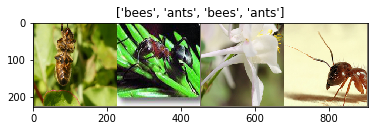

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a baatch of training data
inputs, classes = next(iter(dataloaders['train']))
print(classes)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

input에는 tensor가 저장되고(그림으로 보임), classes에는 0과 1이 지정되며 각각 개미와 벌을 뜻한다.
next와 iter는 반복자를 나타내며 링크 참조바람.
[링크](https://python.bakyeono.net/chapter-7-4.html)

- np.clip : numpy.clip(a, a_min, a_max, out=None), Clip (limit) the values in an array.
- torchvision.utils.make_grid() : Make a grid of images.

## training

- Learning Rate관리
- 최적의 모델 구하기

아래의 scheduler 매개변수는 torch.optim.lr_scheduler의 LR Scheduler 객체(Object)

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

- torch.set_grad_enabled() : mode (bool) – Flag whether to enable grad (True), or disable (False). This can be used to conditionally enable gradients.

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 1. retraining

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
print('num_ftrs : ', num_ftrs)
print(model_ft.fc)
print('-' * 100)
print(model_ft)

num_ftrs :  512
Linear(in_features=512, out_features=2, bias=True)
----------------------------------------------------------------------------------------------------
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

- model.fc.in_features : linear layer의 number of inputs를 뜻함

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6385 Acc: 0.6803
val Loss: 0.5084 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.5791 Acc: 0.7787
val Loss: 0.2336 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4563 Acc: 0.8279
val Loss: 0.2904 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.6178 Acc: 0.7541
val Loss: 0.5076 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.5575 Acc: 0.7377
val Loss: 0.2402 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.5164 Acc: 0.8033
val Loss: 0.2811 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.6234 Acc: 0.8033
val Loss: 0.3298 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.4685 Acc: 0.8279
val Loss: 0.2787 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3352 Acc: 0.8770
val Loss: 0.2393 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3441 Acc: 0.8689
val Loss: 0.2330 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.4213 Acc: 0.8115
val Loss: 0.2368 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3810 Acc: 0.8484
val Loss: 0.2191 Acc: 0.9346

Ep

### etc) model save & load

In [10]:
torch.save(model_ft.state_dict(), './transfer_v1.pkl')

In [11]:
model_ft.load_state_dict(torch.load('./transfer_v1.pkl'))

In [12]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
print('num_ftrs : ', num_ftrs)
print(model_ft.fc)
print('-' * 100)
print(model_ft)

num_ftrs :  512
Linear(in_features=512, out_features=2, bias=True)
----------------------------------------------------------------------------------------------------
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6363 Acc: 0.7131
val Loss: 0.5116 Acc: 0.8497

Epoch 1/24
----------
train Loss: 0.6280 Acc: 0.8033
val Loss: 0.2847 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5204 Acc: 0.7992
val Loss: 0.3048 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.3900 Acc: 0.8525
val Loss: 0.2413 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4684 Acc: 0.8279
val Loss: 0.2012 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4098 Acc: 0.8402
val Loss: 0.9003 Acc: 0.7647

Epoch 6/24
----------
train Loss: 0.4705 Acc: 0.8279
val Loss: 0.3650 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3273 Acc: 0.8689
val Loss: 0.2902 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.3229 Acc: 0.8689
val Loss: 0.3288 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.3309 Acc: 0.8648
val Loss: 0.2511 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3310 Acc: 0.8689
val Loss: 0.2740 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3383 Acc: 0.8689
val Loss: 0.2621 Acc: 0.8954

Ep

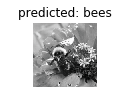

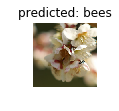

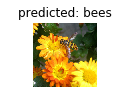

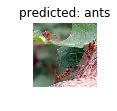

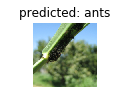

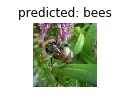

In [15]:
visualize_model(model_ft)

## 2. freeze

In [16]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
num_ftrs

512

In [18]:
model_conv.fc

Linear(in_features=512, out_features=2, bias=True)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.7800 Acc: 0.5984
val Loss: 0.2557 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4541 Acc: 0.7951
val Loss: 0.2896 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4415 Acc: 0.8074
val Loss: 0.2369 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.5676 Acc: 0.7787
val Loss: 0.2531 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.5044 Acc: 0.7828
val Loss: 0.1634 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.4045 Acc: 0.8238
val Loss: 0.1580 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4239 Acc: 0.8197
val Loss: 0.1730 Acc: 0.9608

Epoch 7/24
----------
train Loss: 0.4306 Acc: 0.8033
val Loss: 0.2178 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3380 Acc: 0.8525
val Loss: 0.1630 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4404 Acc: 0.8033
val Loss: 0.1643 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3340 Acc: 0.8525
val Loss: 0.1746 Acc: 0.9673

Epoch 11/24
----------
train Loss: 0.3399 Acc: 0.8484
val Loss: 0.1693 Acc: 0.9542

Ep

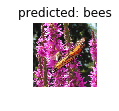

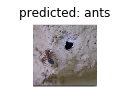

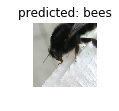

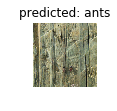

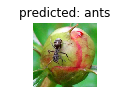

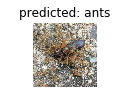

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()

### etc) model save & load



In [21]:
torch.save(model_conv.state_dict(), './transfer_v2.pkl')

In [22]:
model_conv.load_state_dict(torch.load('./transfer_v2.pkl'))

In [23]:
for param in model_conv.parameters():
    param.requires_grad = False
    
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum = 0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6002 Acc: 0.6762
val Loss: 0.4264 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.6279 Acc: 0.7049
val Loss: 0.1733 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.5272 Acc: 0.7500
val Loss: 0.1897 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.6587 Acc: 0.7582
val Loss: 1.1836 Acc: 0.6601

Epoch 4/24
----------
train Loss: 0.6861 Acc: 0.7828
val Loss: 0.1757 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3910 Acc: 0.8238
val Loss: 0.2002 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.5245 Acc: 0.8033
val Loss: 0.1836 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3151 Acc: 0.8730
val Loss: 0.1899 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3018 Acc: 0.8770
val Loss: 0.1816 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3374 Acc: 0.8361
val Loss: 0.1730 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3884 Acc: 0.8361
val Loss: 0.1922 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.4155 Acc: 0.8115
val Loss: 0.1731 Acc: 0.9412

Ep